In [243]:
import numpy as np  #For numerical array processing
import pandas as pd #To handle dataframes
import matplotlib
import matplotlib.pyplot as plt  #For plotting functions
import matplotlib.mlab as mlab  #For specialized matplotlib functionalities
import scipy.stats as stats   #for statistical functions
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline 
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

plt.rcParams['agg.path.chunksize'] = 100000 #To allow for plotting of large datasets
plt.style.use('seaborn-white')
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

Question 1

1. Programmatically download and load into your favorite analytical tool the trip data for September 2015.

2. Report how many rows and columns of data you have loaded.


In [197]:
"""
Load the data into a Pandas dataframe to allow for easy processing and analysis.
"""
def load_data(url):
    df = pd.read_csv(url)   
    return df

url="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
df = load_data(url)
print("The dataset contains %d rows and %d columns."%(df.shape[0],df.shape[1]))

The dataset contains 1494926 rows and 21 columns.


In [228]:
"""
Encode columns into their appropriate types.
"""
def process_columns(df):
    df.VendorID = df.VendorID.astype('category')
    df.RateCodeID = df.RateCodeID.astype('category')
    df.Passenger_count = df.Passenger_count.astype(int)
    df.Payment_type = df.Payment_type.astype('category')
    df.Trip_distance = df.Trip_distance.astype(float)
    #The column Trip_type actually has a space at the end of the header. Hence it needs to be accessed this way.
    df["Trip_type "] = df["Trip_type "].astype('category')
    print("Columns encoded into their respective types.")
    return df
    


df = process_columns(df)
#Check to make sure
assert df.VendorID.dtype.name == 'category', "The encoding didn't go so well. Try again."


Columns encoded into their respective types.


Question 2

1. Plot a histogram of the number of the trip distance ("Trip Distance").

2. Report any structure you find and any hypotheses you have about that structure

Now let's plot the histogram of the Trip Distance.

Text(0.5,0,'Trip Distance in miles')

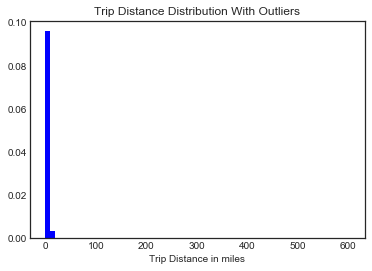

In [230]:

mean = np.mean(df.Trip_distance)
std = np.std(df.Trip_distance)


plt.hist(df.Trip_distance,normed = 1,bins = 60,color = 'b')
plt.title("Trip Distance Distribution With Outliers")
plt.xlabel("Trip Distance in miles")

#ax[0].plot(df.Trip_distance,mlab.normpdf(df.Trip_distance, mean_with_outliers, std_with_outliers),color = 'k')
#ax[0].plot(df.Trip_distance,pdf,color = 'k')


The distribution for Trip Distance is right-skewed, because there is a long tail to the right of the graph.
Another thing we can notice here is that all the values are non-negative as they represent distances.
The distribution peaks very close to zero but the graph continues until 600, which means that there could be outliers.
Let's check for those using box-whisker plots.

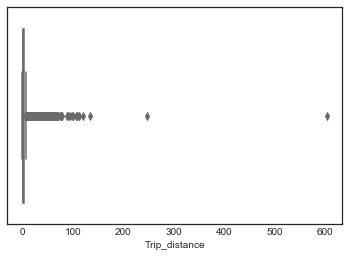

In [231]:
import seaborn as sns
#fig, axs = plt.subplots(1, 2,sharey = True,figsize = [10,5])
ax= sns.boxplot(x=df.Trip_distance)
#Here the box plot shows that there are some anomalies in the trip_distance data. 


We can remove these anomalies by discarding all values that are not within 3 standard deviations of the mean.
Any datapoint outside 3 standard deviations from the mean can be considered as an outlier.

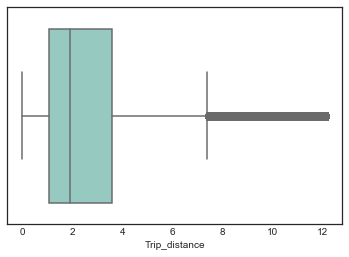

In [232]:
df_without_outliers = df[~(np.abs(df.Trip_distance-df.Trip_distance.mean())>(3*df.Trip_distance.std()))]
sns.boxplot(x=df_without_outliers.Trip_distance)

The outliers were causing the distribution to be extremely skewed to the right. We can now see both distributions side by side, and some of their statistics namely mean, median, standard deviation and interquartile range.


Statistics before outlier removal: 

Mean: 2.96814
Median: 1.98000
Standard Deviation: 3.07662
Interquartile range: 2.64000
Statistics after outlier removal: 

Mean: 2.70476
Median: 1.92000
Standard Deviation: 2.31363
Interquartile range: 2.52000
Plotting the new histogram and distribution after outlier removal: 


'\n\n\n'

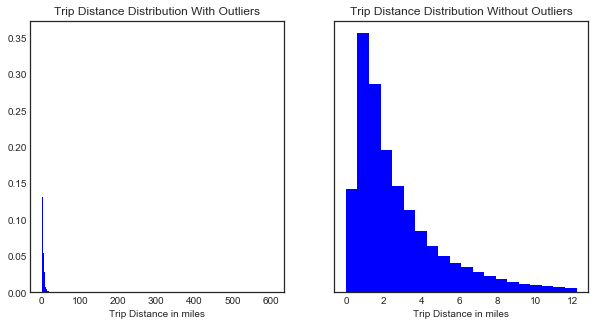

In [234]:

"""
#This looks much better. We can compare the mean, median and standard deviation of Trip Distance
before and after the outliers have been removed.

"""
print("="*80)
print("Statistics before outlier removal: ")
print()
print("Mean: %.5f"%np.mean(df.Trip_distance))
print("Median: %.5f"%np.median(df.Trip_distance))
print("Standard Deviation: %.5f"%np.std(df.Trip_distance))
print("Interquartile range: %.5f"%stats.iqr(df.Trip_distance))

print("="*80)
print("Statistics after outlier removal: ")
print()
print("Mean: %.5f"%np.mean(df_without_outliers.Trip_distance))
print("Median: %.5f"%np.median(df_without_outliers.Trip_distance))
print("Standard Deviation: %.5f"%np.std(df_without_outliers.Trip_distance))
print("Interquartile range: %.5f"%stats.iqr(df_without_outliers.Trip_distance))
print("="*80)


"""
We can plot the histograms and distributions before and after outlier removal.
Since the data is right-skewed and all non-negative, we cannot use a Gaussian 
distribution to model this data. A Gamma distribution can be used to model this data.
The parameters of a Gamma distribution are alpha and beta which can be obtained from the 
mean and standard deviation as follows:

alpha = (mu/sigma)^2
beta = sigma^2/mu
"""

def get_gamma_params(mu,sigma):
    return (mu/sigma)**2, sigma**2/mu

print("Plotting the new histogram and distribution after outlier removal: ")

fig, ax = plt.subplots(1, 2,sharey = True,figsize = [10,5])



mean_with_outliers = np.mean(df.Trip_distance)
std_with_outliers = np.std(df.Trip_distance)

#Gamma parameters
alpha_with_outliers, beta_with_outliers = get_gamma_params(mean_with_outliers, std_with_outliers)
pdf = stats.gamma.pdf(df.Trip_distance, 
                      a=alpha_with_outliers, 
                      scale=1/beta_with_outliers)

#pdf = stats.norm.pdf(df.Trip_distance, mean_with_outliers, std_with_outliers)
#ax[0].plot(df.Trip_distance, pdf,color = 'k')
ax[0].hist(df.Trip_distance,normed = 1,bins = 300,color = 'b')
ax[0].set_title("Trip Distance Distribution With Outliers")
ax[0].set_xlabel("Trip Distance in miles")


mean_without_outliers = np.mean(df_without_outliers.Trip_distance)
std_without_outliers = np.std(df_without_outliers.Trip_distance)

alpha_without_outliers, beta_without_outliers = get_gamma_params(mean_without_outliers, std_without_outliers)
pdf = stats.gamma.pdf(df_without_outliers.Trip_distance, 
                      a=alpha_without_outliers, 
                      scale=1/beta_without_outliers)
#pdf = stats.norm.pdf(df_without_outliers.Trip_distance, mean_without_outliers, std_without_outliers)
#ax[1].plot(df_without_outliers.Trip_distance, pdf,color = 'k')
ax[1].hist(df_without_outliers.Trip_distance,normed = 1,bins = 20,color = 'b');
ax[1].set_title("Trip Distance Distribution Without Outliers")
ax[1].set_xlabel("Trip Distance in miles")
#ax[1].plot(df_without_outliers.Trip_distance,pdf,color = 'k')

"""


"""


In such a distribution, the median is closer to the first quartile than the third,
and also the mean > median. Such a distribution can be modeled by a Gamma distribution instead of a Gaussian because all the datapoints are positive and the distribution is right skewed.

Question 3
1. Report mean and median trip distance grouped by hour of day.

Text(0,0.5,'Number of Trips')

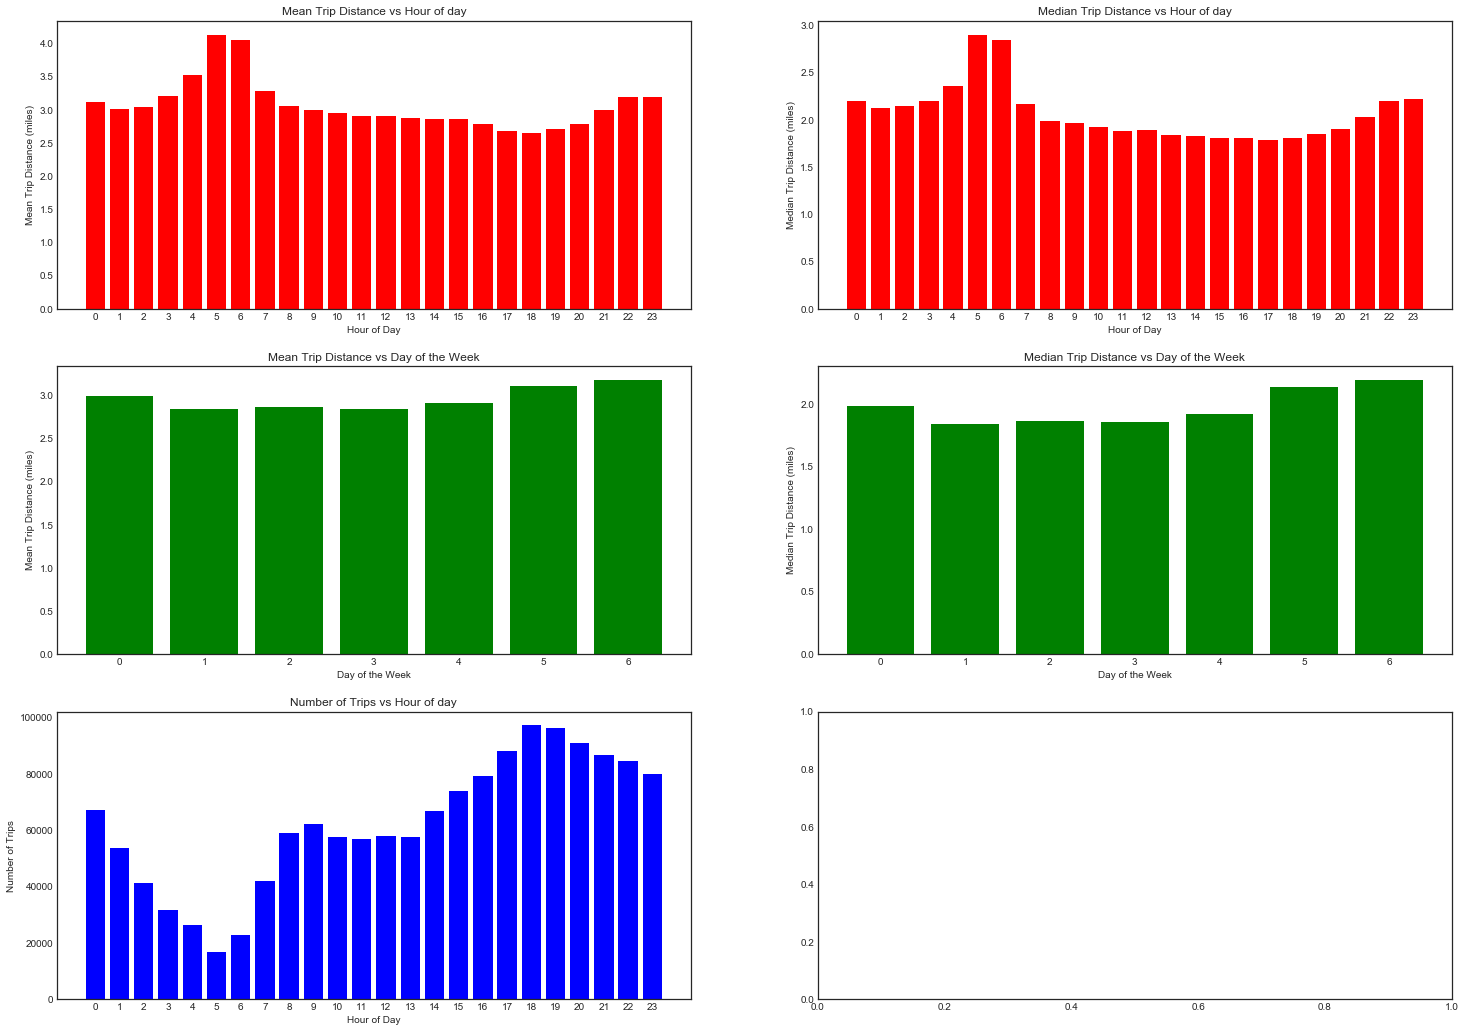

In [235]:
"""
Create a new column called 'hour' to hold this value. While at it, we can also
create columns for week, day (of month), day of week and minute as they may be of use to us later on.
"""
df["hour"] = pd.to_datetime(df.lpep_pickup_datetime).dt.hour
df["day"] = pd.to_datetime(df.lpep_pickup_datetime).dt.day
df["dayofweek"] = pd.to_datetime(df.lpep_pickup_datetime).dt.dayofweek
df["week"] = pd.to_datetime(df.lpep_pickup_datetime).dt.week
df["minute"] = pd.to_datetime(df.lpep_pickup_datetime).dt.minute

fig, axs = plt.subplots(3,2, figsize=[25,18])

#Plot mean trip distance per hour of day
vals = df.groupby("hour")["Trip_distance","hour"].mean()
axs[0][0].bar(vals.hour,vals.Trip_distance,color = 'r')
axs[0][0].set_title("Mean Trip Distance vs Hour of day")
axs[0][0].set_xlabel("Hour of Day")
axs[0][0].set_xticks(vals.hour)
axs[0][0].set_ylabel("Mean Trip Distance (miles)")


#Plot median trip distance per hour of day
vals = df.groupby("hour")["Trip_distance","hour"].median()
axs[0][1].bar(vals.hour,vals.Trip_distance, color = 'r')
axs[0][1].set_title("Median Trip Distance vs Hour of day")
axs[0][1].set_xlabel("Hour of Day")
axs[0][1].set_xticks(vals.hour)
axs[0][1].set_ylabel("Median Trip Distance (miles)")

print("="*80)

#Mean trip distance per day of the week
vals = df.groupby("dayofweek")["Trip_distance","dayofweek"].mean()
axs[1][0].bar(vals.dayofweek,vals.Trip_distance, color = 'g')
axs[1][0].set_title("Mean Trip Distance vs Day of the Week")
axs[1][0].set_xlabel("Day of the Week")
axs[1][0].set_xticks(vals.dayofweek)
axs[1][0].set_ylabel("Mean Trip Distance (miles)")


#Median trip distance per day of the week
vals = df.groupby("dayofweek")["Trip_distance","dayofweek"].median()
axs[1][1].bar(vals.dayofweek,vals.Trip_distance, color = 'g')
axs[1][1].set_title("Median Trip Distance vs Day of the Week")
axs[1][1].set_xlabel("Day of the Week")
axs[1][1].set_xticks(vals.dayofweek)
axs[1][1].set_ylabel("Median Trip Distance (miles)")

"""
It would be interesting to see how many rides occurred during the each hour of the day.
Let's plot that.
"""
#Number of trips per hour of day
vals = df.groupby("hour")["VendorID"].count()
axs[2][0].bar(range(0,24),vals.values,color = 'b')
axs[2][0].set_title("Number of Trips vs Hour of day")
axs[2][0].set_xlabel("Hour of Day")
axs[2][0].set_xticks(range(0,24))
axs[2][0].set_ylabel("Number of Trips")





In the above graphs, we can see that both the median and mean trip distances peak during 5am to 7am over the course of the month. However if we look at the first graph on the third row, the number of trips are the lowest from 5 am to 7 am among all the other hours. This shows that the distance covered on average is a lot higher during the hours where the number of trips taken is very less. Why could this be?

One possibility could be that during early morning hours, people are generally rushing for work. And if someone lives far away and is unable to make it to the subway on time, they tend to could be more inclined to go for a taxi.







Question 2. 

We'd like to get a rough sense of identifying trips that originate or 
terminate at one of the NYC area airports. Can you provide a count of 
how many transactions fit this criteria, the average fare, and any other 
interesting characteristics of these trips.

From the data dictionary, we can see the following definition for RateCodeID :- 
The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride

So, in order to determine trips originating/terminating at airports, we can take all rows where
RateCodeID = 2 or 3. One thing to note is that in determining airport trips, we should not remove outliers, 
because airport trips tend to me anomalous in general and cost a lot. So these outliers would be required.
Also, trips to LaGuardia airport are not represented by the RateCodeID column.


We can see that there are 5552 trips to or from the JFK and Newark airport out of a total of 1494926 trips.
          This is assuming the RateCodeID column provides the information we need. However, this RateCodeID fare does
          not cover LaGuardia Airport, which is also not in the vicinity of Manhattan. This could mean that Green taxis could
          ply to LaGuardia, and we have no information about this. So 0.37 percent of Green Taxi 
          trips during September 2015 were made to and from airports.
        
On average, a trip that originated or terminated at JFK or Newark airport costed $48.977, given our prior 
          assumption about RateCodeID

    And on average, people ended up paying $57.21 for travelling to and from airports in NYC. 
    This is the total amount including other extra charges.


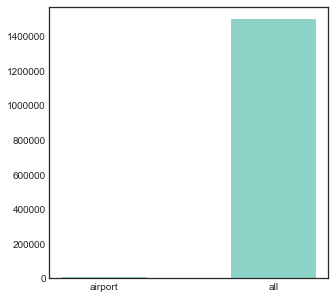

In [236]:
def find_airport_trips(df):
    print("="*80) #For separation during printing
    airport_trips = df[(df["RateCodeID"]==2)|(df["RateCodeID"]==3)]
    num_all_trips = len(df)
    num_airport_trips = len(airport_trips)

    #Plot bar graph of all trips vs airport trips
    fig = plt.figure(figsize=[5,5])
    plt.bar(["all","airport"],[num_all_trips,num_airport_trips ],width = 0.5)


    mean_airport_fare = airport_trips["Fare_amount"].mean()
    mean_total_amount = airport_trips["Total_amount"].mean()
    print(
        """We can see that there are %d trips to or from the JFK and Newark airport out of a total of %d trips.
          This is assuming the RateCodeID column provides the information we need. However, this RateCodeID fare does
          not cover LaGuardia Airport, which is also not in the vicinity of Manhattan. This could mean that Green taxis could
          ply to LaGuardia, and we have no information about this. So %.2f percent of Green Taxi 
          trips during September 2015 were made to and from airports.
        """ %(num_airport_trips,
              num_all_trips,
              num_airport_trips*100/num_all_trips
             ))
    print("="*80)
    print("""On average, a trip that originated or terminated at JFK or Newark airport costed $%.3f, given our prior 
          assumption about RateCodeID""" %mean_airport_fare)
    print(
    """
    And on average, people ended up paying $%.2f for travelling to and from airports in NYC. 
    This is the total amount including other extra charges.""" %mean_total_amount)
    print("="*80)
    return airport_trips
airport_trips = find_airport_trips(df)

To investigate further, let's look more carefully at the airport trips and corroborate the analysis we did earlier.
If we had a LocationID column provided to us, then we could have located the airport trips very easily by 
joining with the taxi_zone_lookup data provided on the same website. But, we are out of luck there.
So we can look at the latitudes and longitudes of the three airports near NYC.
Here they are (from Google):

Newark - 40.6895314 and the longitude is: -74.17446239999998.
LaGuardia : 40.7769271 and the longitude is: -73.87396590000003.
JFK : 40.6441666667, -73.7822222222

Any latitude and longitude close to these will be in the airport area


In [238]:
"""

But every longitude and latitude given to us has a slightly different precision. 
So how do we determine which longitudes and latitudes represent the airport areas?
Well according to Wikipedia:

Accuracy versus decimal places at the equator

decimal  degrees    distance
places
-------------------------------  
0        1.0        111 km
1        0.1        11.1 km
2        0.01       1.11 km
3        0.001      111 m
4        0.0001     11.1 m
5        0.00001    1.11 m
6        0.000001   0.111 m
7        0.0000001  1.11 cm
8        0.00000001 1.11 mm
ref : https://en.wikipedia.org/wiki/Decimal_degrees#Precision

So if we round off the latitude and longitude values to 4 decimal places, we should get an accurate representation
of the trips that fall within 11.1 meters from the concerned location, i.e. the airport.
"""
df_without_outliers["Dropoff_latitude_rounded"] = round(df_without_outliers["Dropoff_latitude"],7)
df_without_outliers["Dropoff_longitude_rounded"] = round(df_without_outliers["Dropoff_longitude"],7)
df_without_outliers["Pickup_latitude_rounded"] = round(df_without_outliers["Pickup_latitude"],7)
df_without_outliers["Pickup_longitude_rounded"] = round(df_without_outliers["Pickup_longitude"],7)
#Let's check
lat_long_data = df_without_outliers[["Dropoff_latitude_rounded",
                    "Dropoff_longitude_rounded",
                    "Pickup_latitude_rounded",
                    "Pickup_longitude_rounded"]]

airport_true_lats = np.round(np.array([40.6895314,40.7769271,40.6441666667]),7)
airport_true_longs = np.round(np.array([-74.17446239999998,-73.87396590000003,-73.7822222222]),7)
df_without_outliers["Airport_trips2"] = [0] * len(lat_long_data)

"""
##Tried this method but it's computationally intractable.
for i in range(len(lat_long_data)):
    if (df_without_outliers["Pickup_latitude_rounded"].iloc[i] in airport_true_lats or
        df_without_outliers["Dropoff_latitude_rounded"].iloc[i] in airport_true_lats or
        df_without_outliers["Pickup_longitude_rounded"].iloc[i] in airport_true_longs or
        df_without_outliers["Dropoff_longitude_rounded"].iloc[i] in airport_true_longs):
        df_without_outliers["Airport_trips2"].iloc[i] = 1
"""
newark_orig = np.sum(np.where((abs(df_without_outliers["Pickup_latitude_rounded"] - airport_true_lats[0]) <= 0.0001) 
                              & (abs(df_without_outliers["Pickup_longitude_rounded"] - airport_true_longs[0]) <= 0.0001), 1, 0))
   

laguardia_orig = np.sum(np.where((abs(df_without_outliers["Pickup_latitude_rounded"] - airport_true_lats[1]) <= 0.0001 )
                                 & (abs(df_without_outliers["Pickup_longitude_rounded"] - airport_true_longs[1]) <= 0.0001), 1, 0))
   
jfk_orig = np.sum(np.where((abs(df_without_outliers["Pickup_latitude_rounded"] - airport_true_lats[2]) <= 0.0001 )
                              & (abs(df_without_outliers["Pickup_longitude_rounded"] - airport_true_longs[2]) <= 0.0001), 1, 0))
   


newark_term = np.sum(np.where((abs(df_without_outliers["Dropoff_latitude_rounded"] - airport_true_lats[0]) <= 0.0001 )
                              & (abs(df_without_outliers["Dropoff_longitude_rounded"] - airport_true_longs[0]) <= 0.0001), 1, 0))

laguardia_term = np.sum(np.where((abs(df_without_outliers["Dropoff_latitude_rounded"] - airport_true_lats[1]) <= 0.0001 )
                              & (abs(df_without_outliers["Dropoff_longitude_rounded"] - airport_true_longs[1]) <= 0.0001), 1, 0))

jfk_term = np.sum(np.where((abs(df_without_outliers["Dropoff_latitude_rounded"] - airport_true_lats[2]) <= 0.0001 )
                              & (abs(df_without_outliers["Dropoff_longitude_rounded"] - airport_true_longs[2]) <= 0.0001), 1, 0))



print("Number of trips originating at Newark airport: %d"%newark_orig)
print("Number of trips terminating at Newark airport: %d"%newark_term)
print("Number of trips originating at LaGuardia airport: %d"%laguardia_orig)
print("Number of trips terminating at LaGuardia airport: %d"%laguardia_term)
print("Number of trips originating at JFK airport: %d"%jfk_orig)
print("Number of trips terminating at JFK airport: %d"%jfk_term)

Number of trips originating at Newark airport: 0
Number of trips terminating at Newark airport: 0
Number of trips originating at LaGuardia airport: 0
Number of trips terminating at LaGuardia airport: 0
Number of trips originating at JFK airport: 1
Number of trips terminating at JFK airport: 37


The above analysis does not seemed to have worked well, because the number of trips calculated via this method does not match with that calculated using RateCodeID. Possible explanations for this could be that the latitudes and longitudes may have errors in them; or the method just was not the correct way of doing it. If time permitted, this could be looked into in more detail. But for now, we will go ahead with the number of trips obtained earlier.

So now that we have determined the number of airport trips, let's see when they occur the most.

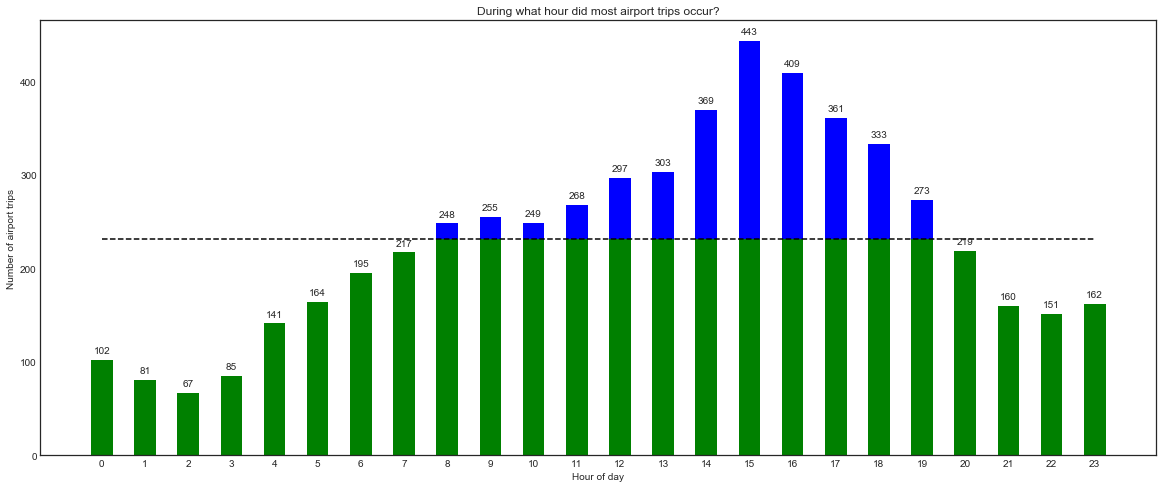

In [239]:
#What hour of day did airport trips happen?
airport_trips_per_hour = airport_trips.groupby("hour")["hour"].count().values
avg_trips_per_hr = np.mean(airport_trips_per_hour)
m = len(airport_trips_per_hour) #No. of hours

#Plot
fig,ax = plt.subplots(1,1,figsize=[20,8])
ax.set_title("During what hour did most airport trips occur?")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of airport trips")
ax.set_xticklabels(range(0,m))
ax.set_xticks(range(0,m))
plt.bar(range(0,m), airport_trips_per_hour, color = 'b',width = 0.5 )

#Color everything below the average line in green
plt.bar(range(0,m), [min(item,avg_trips_per_hr) for item in airport_trips_per_hour], 
        color = 'g', width = 0.5)


#Plot an average line
plt.plot(range(0,m), [avg_trips_per_hr]*m,'--',color = 'k')

labels = [str(int(i)) for i in airport_trips_per_hour]

for rect, label in zip(ax.patches, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()




From the chart, we can observe that most trips to and from the airport occur in the 3pm - 5pm interval.
People generally like to be early for their flight, and this leads me to believe that many flights depart at around 5-7pm.

Similarly, this could include pickups from the airport as well, which means that flights most probably arrive at the airports
during the 12 pm to 2 pm interval

Now we can determine which days of the week do people like to fly the most.

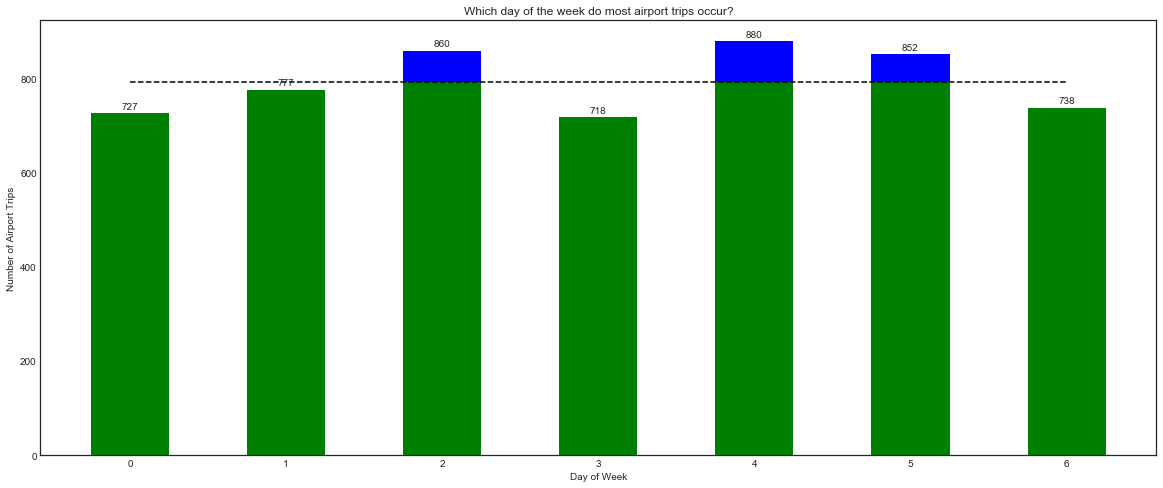

In [240]:

airport_trips_per_dayofweek = airport_trips.groupby("dayofweek")["day"].count().values 
avg_trips_per_dayofweek = np.mean(airport_trips_per_dayofweek)

fig,ax = plt.subplots(1,1,figsize=[20,8])
ax.set_title("Which day of the week do most airport trips occur?")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Number of Airport Trips")
ax.set_xticklabels(range(0,7))
ax.set_xticks(range(0,7))
plt.bar(range(0,7), airport_trips_per_dayofweek, color = 'b',width = 0.5 )

#Color everything below the average line in green
plt.bar(range(0,7), [min(item,avg_trips_per_dayofweek) 
                      for item in airport_trips_per_dayofweek], color = 'g', width = 0.5)
#Plot an average line
plt.plot(range(0,7), [avg_trips_per_dayofweek]*7,'--',color = 'k')

labels = [str(int(i)) for i in airport_trips_per_dayofweek]

for rect, label in zip(ax.patches, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()


From the graph, we can say that there isn't much standard deviation about the mean, and not much can be said about this 
data. People seem to travel to and from the airport more on Wednesday, Friday and Saturday. Although we cannot infer much about
Wednesday from this data, we can see that people prefer to fly closer to the weekend.


<br>
Question 4

Build a derived variable for tip as a percentage of the total fare.

Build a predictive model for tip as a percentage of the total fare. 
Use as much of the data as you like (or all of it). We will validate a sample.
</br>

In [241]:
"""
A function to scale the data to values between 0 and 1.
"""
def scale_data(df):
        from sklearn import preprocessing
        x = df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return pd.DataFrame(x_scaled)

"""
Function to perform preprocessing on the dataset before using if for prediction.
"""
def prepare_prediction_data(df):
    
    #Only take the columns that we can use for the prediction.
    pred_df = df[["VendorID","Store_and_fwd_flag", "RateCodeID", 
             "Passenger_count", "Fare_amount", "Extra", "MTA_tax",
              "Tolls_amount", "improvement_surcharge", 
              "Total_amount","Payment_type","Trip_type ", 
              "hour","day","dayofweek","week","Tip_amount",
             "Pickup_latitude","Pickup_longitude","Dropoff_latitude",
             "Dropoff_longitude"]]
    #Sanity checking on the column names
    pred_df.columns = [c.lower().lstrip().rstrip() for c in pred_df.columns]
    print("Shape of original dataframe: " + str(pred_df.shape))
    """
    Since we don't have information about cash tips, having them in the prediction model
    will skew the data drastically. One thing that could be done is to interpolate the tip amounts into
    trips that were paid for by cash. Then again, by doing this we assume that every traveler tipped, which
    may not be the case. We will try to tackle both approaches.

    """

    #Remove all cash-trips
    pred_df = pred_df[pred_df["payment_type"]!=2]
    print("Shape of dataframe after removal of cash trips: " + str(pred_df.shape))
    #Remove all trips where total fare is less than or equal to zero
    pred_df = pred_df[pred_df["total_amount"] >= 0]
    print("Shape of dataframe after restricting to positive fares only: " + str(pred_df.shape))

    #Create a derived variable as per the problem statement
    #The tip amount is asked as a percentage of total fare
    #So we can convert it into that form.
    pred_df["trip_fare_ratio"] = pred_df["tip_amount"]/pred_df["fare_amount"] 

    #Convert all infinity values to NaN and remove all NaN records
    with pd.option_context('mode.use_inf_as_null', True):
        pred_df = pred_df.dropna()
    
    print("Shape of dataframe after removal of NaN records: " + str(pred_df.shape))

    #Intermediate dataframe with continuous variables only.
    cont_df = pred_df[["passenger_count","tolls_amount",
                       "fare_amount", "extra", "mta_tax",
                       "improvement_surcharge","total_amount",
                       "pickup_latitude","pickup_longitude",
                       "dropoff_latitude","dropoff_longitude"
                      ]].astype(float)

    #Scale the values to a range of 0-1. This is done to ensure proper convergence of the Machine Learning models.
    #A large value of one column alongside a small value in another column will cause numerical errors.
    cont_df = scale_data(cont_df)

    """
    We need to one-hot encode categorical variables before making any predictions.
    We also need to convert each dummy variable into a float value as the regression function
    expects this form of input.
    """
    vend = pd.get_dummies(pred_df.vendorid).astype(float)
    store = pd.get_dummies(pred_df.store_and_fwd_flag).astype(float)
    ratecodeid = pd.get_dummies(pred_df.ratecodeid).astype(float)
    paytype = pd.get_dummies(pred_df.payment_type).astype(float)
    triptype = pd.get_dummies(pred_df.trip_type).astype(float)
    dayofweek = pd.get_dummies(pred_df.dayofweek).astype(float)
    hour = pd.get_dummies(pred_df.hour).astype(float)
    
    #Stack the continous variables with the categorical variables to obtain the final features.
    feats = np.hstack((np.array(cont_df), vend, store, ratecodeid, paytype, triptype, dayofweek,hour))
    #Labels are true output, which in this case is the trip_fare_ratio
    labels = pred_df["trip_fare_ratio"]


    #Now we can split this into train, validation and test sets.
    #A validation set is required for hyperparameter tuning. We do not want to bias our results
    #by tweaking our hyperparameters on the test set. It should remain completely unknown to the model.
    X_train,X_valid,y_train,y_valid = train_test_split(feats,labels, random_state =42, test_size = 0.1) 
    X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, random_state =42, test_size = 0.1) 
    
    #Create a dictionary to hold these separate sets
    data_sep = {"X_train":X_train, "y_train":y_train,
                "X_valid": X_valid, "y_valid": y_valid,
                "X_test": X_test, "y_test":y_test}
    print("Done.")
    return feats, labels, data_sep

feats, labels, data_sep = prepare_prediction_data(df)

Shape of original dataframe: (1494926, 21)
Shape of dataframe after removal of cash trips: (711227, 21)
Shape of dataframe after restricting to positive fares only: (709015, 21)
Shape of dataframe after removal of NaN records: (708244, 22)


Now we have a set of features and the output. Let's build a model!
We will try several models and choose the one that is best.

In [250]:

"""
Inputs: 
1. d - a dictionary containing training, testing and validation data.
Outputs:
None
"""

def train_model(d):
    X_train = d["X_train"]
    y_train = d["y_train"]
    X_valid = d["X_valid"]
    y_valid = d["y_valid"]
    X_test = d["X_test"]
    y_test = d["y_test"]
    
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    # Make predictions using the validation set
    y_pred_regr = regr.predict(X_valid)
    # The mean squared error
    print("Linear Regression without Regularization")
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_regr))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_regr))
    print("="*80)

    ############################################################
    print("Ridge Regression")
    ridge_reg = linear_model.Ridge (alpha = .5)
    # Train the model using the training sets
    ridge_reg.fit(X_train, y_train)

    # Make predictions using the validation set
    y_pred_ridge = ridge_reg.predict(X_valid)

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_ridge))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_ridge))

    print("="*80)
    ############################################################
    print("Lasso Regression")
    lasso_reg = linear_model.Lasso (alpha = .1)
    # Train the model using the training sets
    lasso_reg.fit(X_train, y_train)

    # Make predictions using the validation set
    y_pred_lasso = lasso_reg.predict(X_valid)

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_lasso))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_lasso))

    print("="*80)
    ############################################################

    print("Elastic Net Regression")
    elnet_reg = linear_model.ElasticNet (random_state=0)
    # Train the model using the training sets
    elnet_reg.fit(X_train, y_train)

    # Make predictions using the validation set
    y_pred_elnet = elnet_reg.predict(X_valid)

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_elnet))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_elnet))

    print("="*80)
    ############################################################

    print("Stochastic Gradient Descent Regression")
    sgd_reg = linear_model.SGDRegressor()
    # Train the model using the training sets
    sgd_reg.fit(X_train, y_train)

    # Make predictions using the validation set
    y_pred_sgd = sgd_reg.predict(X_valid)

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_sgd))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_sgd))

    print("="*80)
    ############################################################
    print("XGBoost")
    xgdmat=xgb.DMatrix(X_train,y_train)
    our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,
                'objective':'reg:linear','max_depth':7,'min_child_weight':3}
    final_gb=xgb.train(our_params,xgdmat)
    tesdmat=xgb.DMatrix(X_valid)
    y_pred_xgb=final_gb.predict(tesdmat)

    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(y_valid, y_pred_xgb))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_valid, y_pred_xgb))
    
    #Return the trained models
    return {"linear": regr,
            "ridge" : ridge_reg,
            "lasso" : lasso_reg,
            "elasticnet" : elnet_reg,
            "sgd" : sgd_reg,
            "xgb" : final_gb}


models = train_model(data_sep)
y_test_pred = models["xgb"].predict(xgb.DMatrix(data_sep["X_test"]))
print("Output on test data")
# The mean squared error on the XGBoost
print("Mean squared error on the test data with the XGBoost model is: %.2f"% mean_squared_error(data_sep["y_test"], y_test_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(data_sep["y_test"], y_test_pred))

Linear Regression without Regularization
Mean squared error: 0.16
Variance score: 0.48
Ridge Regression
Mean squared error: 0.16
Variance score: 0.46
Lasso Regression
Mean squared error: 0.31
Variance score: -0.00
Elastic Net Regression
Mean squared error: 0.31
Variance score: -0.00
Stochastic Gradient Descent Regression
Mean squared error: 0.30
Variance score: 0.01
XGBoost
Mean squared error: 0.11
Variance score: 0.64
Mean squared error on the test data with the XGBoost model is: 0.22
Variance score: 0.48


The model outputs a value between 0 and 1 representative of the ratio between tip and total fare. So to obtain the tip amount, the predicted output needs to be multiplied with the total fare.

The r2 score represents how good the model is at explaining the data. So the higher the r2 score, the better the model.
On the other hand, the mean squared error should be low. So in this case, the xgboost model performs the best without any tuning of parameters. The increasing of min_child_weight and max_depth increased the variance and decreased the mean squared error on the train, validation and test sets. Hyperparameter tuning with grid search could achieve better results, but due to the lack of compute and time, I decided against it.

Question 5
Option E: Your own curiosity!

If the data leaps out and screams some question of you that we haven't asked, 
ask it and answer it! Use this as an opportunity to highlight your special skills and philosophies.

So here, I wanted to explore three things. 
1. When do most trips occur, and possibly why?
2. Would it be possible to predict the number of cab trips on an hourly basis or even on a minute-wise basis?
3. Is there a relationship between the amount of surcharge and the tip amount?


How does the number of trips vary per day of the month?

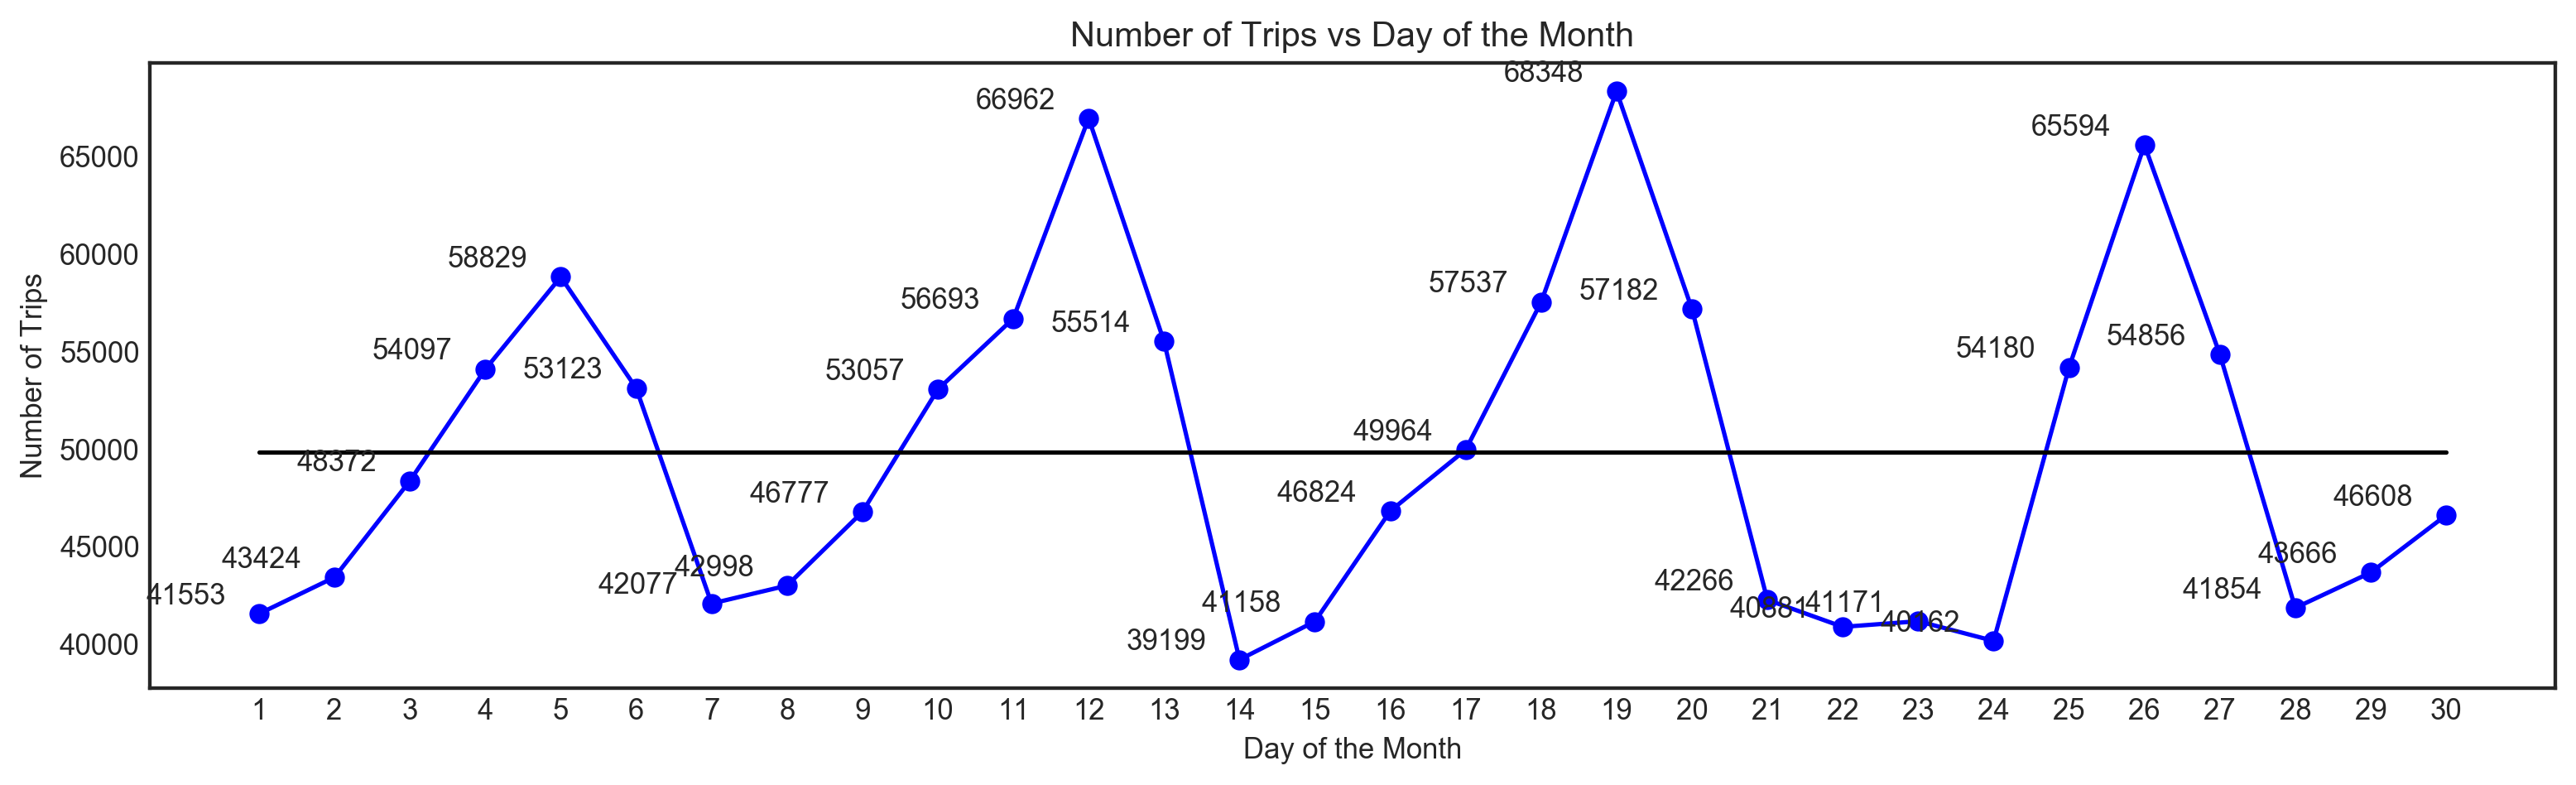

In [219]:
"""
Plot the number of trips per day of the month.
"""

matplotlib.rcParams.update({'font.size': 10})
#Number of trips per day of the month
vals = df.groupby("day")["VendorID"].count()
fig = plt.figure(figsize=[15,4])
plt.plot(range(1,31),vals.values,color = 'b',marker='o')
plt.title("Number of Trips vs Day of the Month")
plt.xlabel("Day of the Month")
plt.xticks(range(1,31))
plt.ylabel("Number of Trips")
for i,j in zip(range(1,31),vals.values):
    plt.text(i-1.5, j + 500, str(j))
#Plot the average line
plt.plot(range(1,31),[np.mean(vals.values)]*30,color = 'k' )
plt.show()



The number of taxi trips have local peaks on the 5th, 12th, 19th and 26th of September, keeping in mind that our
indexing is from 0 and not 1. These are Saturdays.
One hypothesis for these peaks could be that people generally tend go out with friends and family on Saturday nights.
Let's see if hypothesis is true, by plotting the Saturday trips, hour-wise. 

Let's see if the Saturday trips have any location in common. We will not remove outliers/anomalies in this segment.
This is because we cannot be sure that a trip is invalid, because it has been logged. So we assume that the change to the 
actual analysis is minimal, as we are interested in the variations and concentrations as a whole.

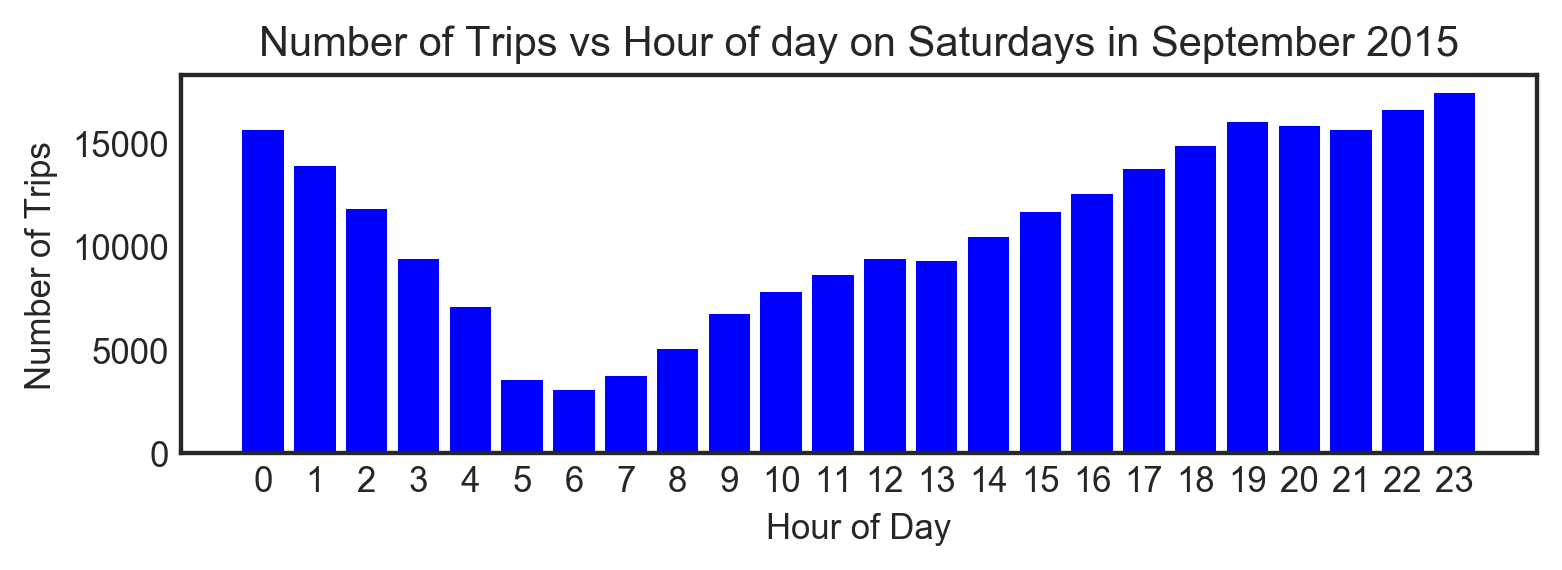

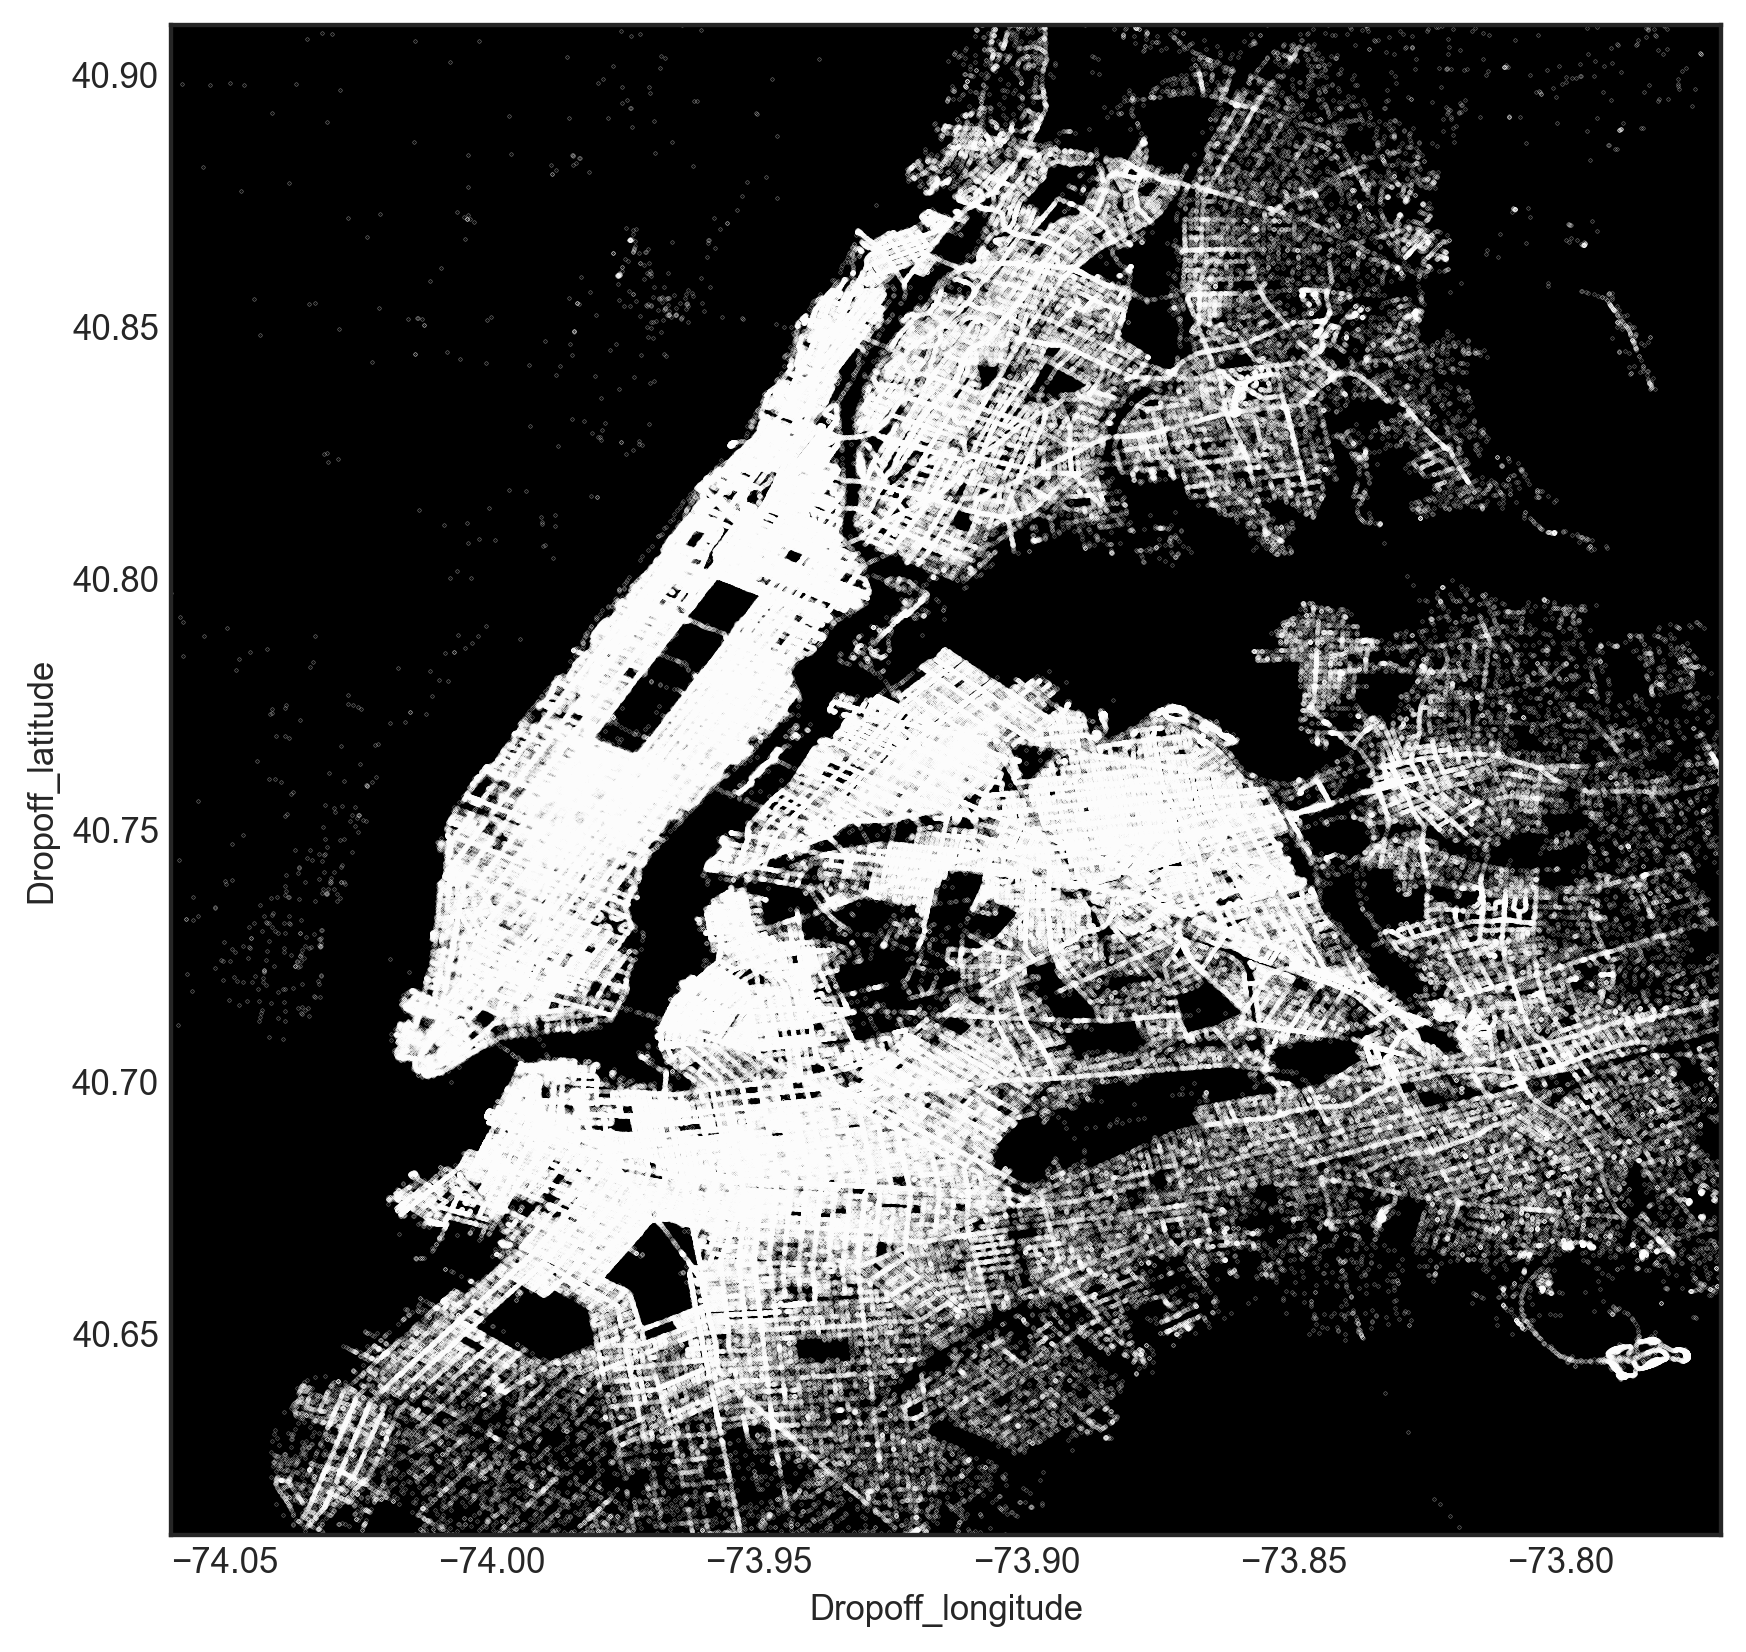

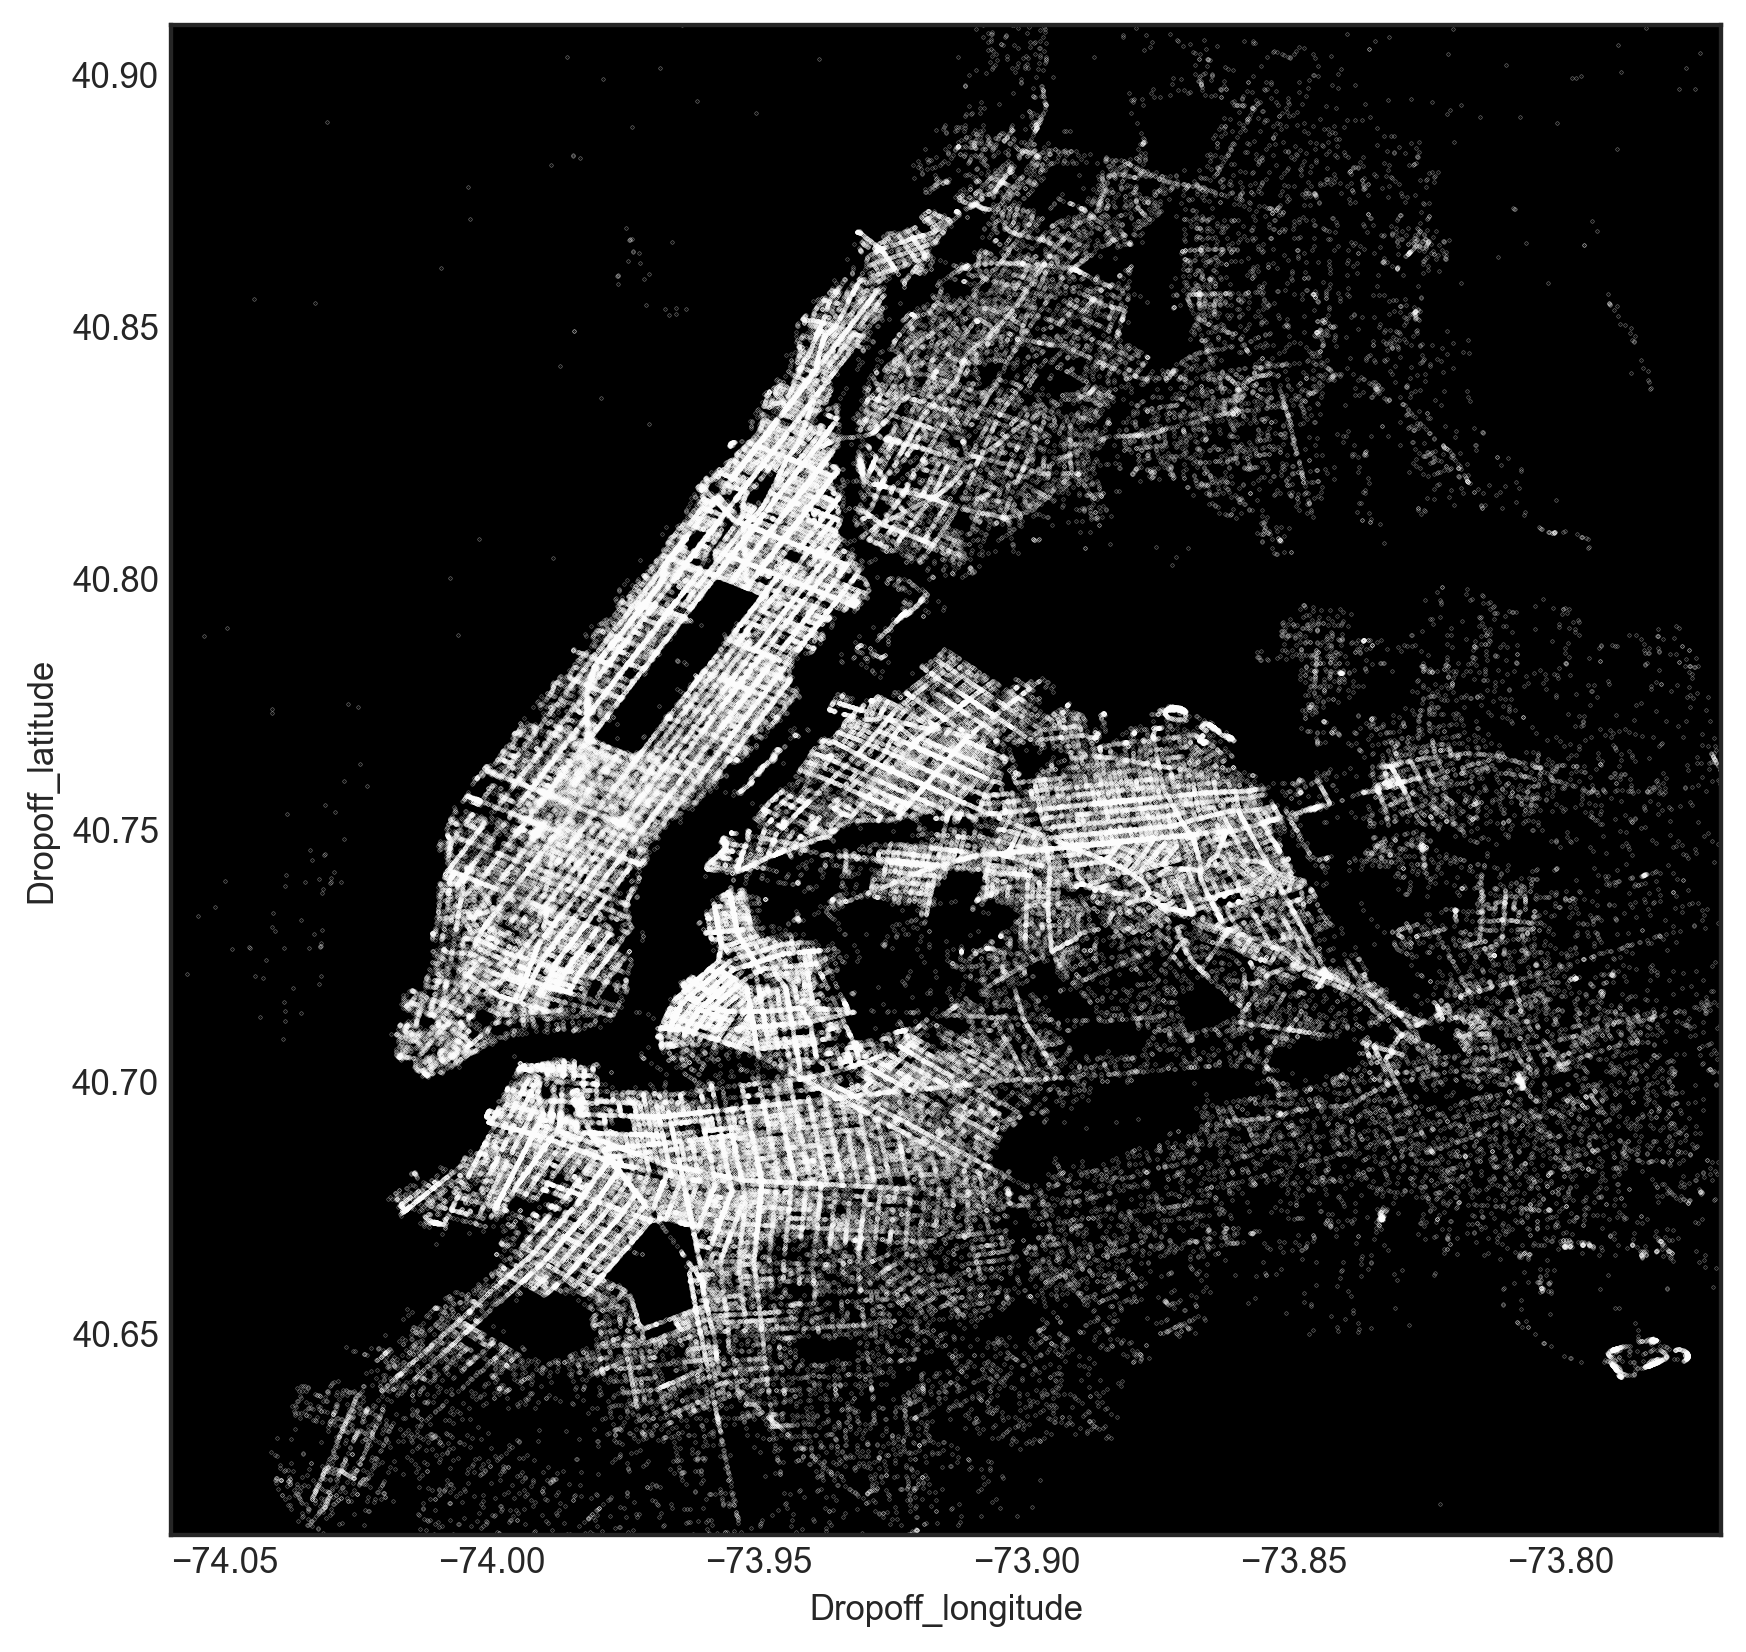

In [220]:
def analyze_saturday_trips(df):
    #Gather all Saturday trips
    saturday_trips = df[(df["day"] == 5)|(df["day"] == 12)|(df["day"] == 19)|(df["day"] == 26)]

    #At what time of the day did these Saturday trips occur?
    vals = saturday_trips.groupby("hour")["VendorID"].count()
    fig = plt.figure(figsize=(7,2))
    plt.bar(range(0,24),vals.values,color = 'b')
    plt.title("Number of Trips vs Hour of day on Saturdays in September 2015")
    plt.xlabel("Hour of Day")
    plt.xticks(range(0,24))
    plt.ylabel("Number of Trips")
    return saturday_trips

saturday_trips = analyze_saturday_trips(df)
"""
We can use the reference at http://www.danielforsyth.me/mapping-nyc-taxi-data/
to draw a map of all trips and also the map of all Saturday trips
""" 
new_style = {'grid': False} #Remove grid  
matplotlib.rc('axes', **new_style)  
from matplotlib import rcParams  
rcParams['figure.figsize'] = (8, 8) #Size of figure  
rcParams['figure.dpi'] = 250


P=df.plot(kind='scatter', x='Dropoff_longitude', y='Dropoff_latitude',
                     color='white',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('black') #Background Color
P2=saturday_trips.plot(kind='scatter', x='Dropoff_longitude', y='Dropoff_latitude',
                     color='white',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P2.set_axis_bgcolor('black') #Background Color

The number of trips on Saturdays are high. Looking at the hourly plot, we can see that the number of trips during
the late night and early morning hours are considerably higher than that during other times of the day. This could be
attributed to people going out on Friday nights (and possibly having had a drink or two) taking taxis back home in order
to avoid drinking and driving, or take the subway when in an inebriated state. 

It could also just be that people don't feel like taking the subway after going out on a fun-filled night. Subway safety issues
may also be of concern at such hours of the day.

The first map figure shows all the trips that occured in September 2015. There is nothing special about it as all areas are highlighted equally brightly.

The second map however, shows only the trips that were made on Saturday and it can be seen that only the central parts of NYC seem to be lit up the most. So the adds support to the belief that people tend to go into the city to visit restaurants and clubs, rather than the boroughs on the outskirts.

Given more time, I would possibly locate the boroughs with most nightlife activity and try to correlate the number of trips with those locations.



<br>
Now to explore the possibility of predicting the number of trips that will occur in the future.
Since this is time series data, we can use LSTM networks for prediction of future values. 
By no means is this the simplest method out there. I wanted to explore this out of pure curiosity.
But however, other simpler time-series methods do exist and can be tried out as part of the future work.
LSTM stands for Long-Short term Memory and is a type of Recurrent Neural Network that is able 
to "remember" some of the values it has encountered in the past. It updates its values based on the 
previous value, and also based on the memory it has of values that have occurred before.

More info. on these networks can be obtained from this amazing blog by Andrew Karpathy 
http://karpathy.github.io/2015/05/21/rnn-effectiveness/
LSTM networks have performed very well on time-series data, especially in the financial sector.

To use an LSTM network, we need to format our data in a specific way.
If X is the number of trips per minute, then we need to shift X by 1 step to obtain Y, the prediction.
In essence, you are using the trips that occurred during the current minute to predict trips that will
occur in the next minute.

For example:
X = 1 2 3 4
Y = 2 3 4 ...

</br>

Training LSTM model...
Epoch 1/100
647/647 [==============================] - 3s 5ms/step - loss: 0.1064
Epoch 2/100
647/647 [==============================] - 0s 349us/step - loss: 0.0299
Epoch 3/100
647/647 [==============================] - 0s 357us/step - loss: 0.0218
Epoch 4/100
647/647 [==============================] - 0s 356us/step - loss: 0.0173
Epoch 5/100
647/647 [==============================] - 0s 351us/step - loss: 0.0135
Epoch 6/100
647/647 [==============================] - 0s 380us/step - loss: 0.0105
Epoch 7/100
647/647 [==============================] - 0s 353us/step - loss: 0.0086
Epoch 8/100
647/647 [==============================] - 0s 358us/step - loss: 0.0076
Epoch 9/100
647/647 [==============================] - 0s 380us/step - loss: 0.0072
Epoch 10/100
647/647 [==============================] - 0s 356us/step - loss: 0.0070
Epoch 11/100
647/647 [==============================] - 0s 360us/step - loss: 0.0070
Epoch 12/100
647/647 [==============================]

647/647 [==============================] - 0s 356us/step - loss: 0.0068
Epoch 98/100
647/647 [==============================] - 0s 350us/step - loss: 0.0068
Epoch 99/100
647/647 [==============================] - 0s 351us/step - loss: 0.0068
Epoch 100/100
647/647 [==============================] - 0s 377us/step - loss: 0.0068
Train Score: 358.48 RMSE
Test Score: 388.36 RMSE


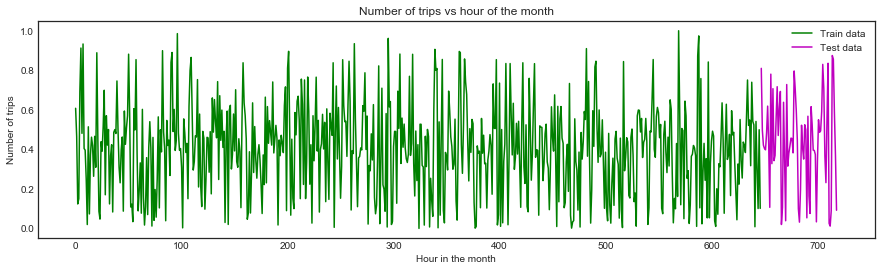

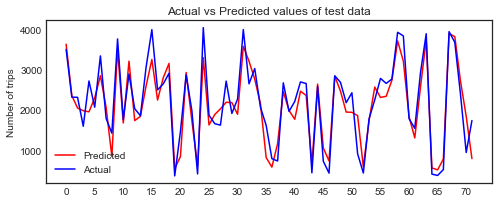

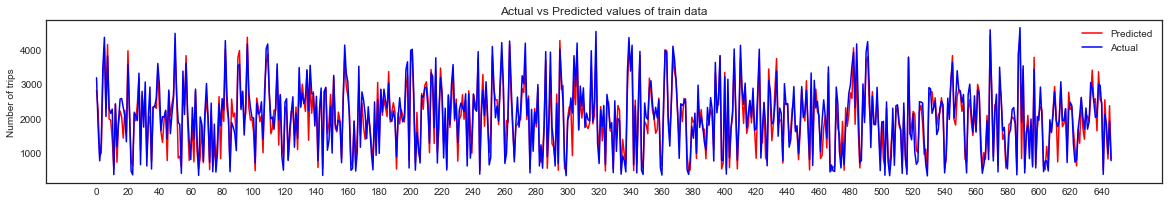

In [253]:
"""
Prepares the training data as required by the LSTM network. 
Inputs:
1. df - original dataframe
2. level - amount of precision you want with the time series modeling. It is set to "hour" by default.
This means that it will take data for every hour in the month of September 2015. Other options are "day" and "minute"


"""
def prep_train_data(df,level = "hour"):
    
    if level == "hour":
        #We will obtain trips per hour and then if time permits, we can run the model on minute-wise data as well.
        hourly_trips = np.reshape(df.groupby(("day","hour"))["VendorID"].count().values,(-1,1))
        #We can use sklearn's in-built scaler to normalize our data
        scaler = MinMaxScaler(feature_range=(0, 1))
        hourly_trips = scaler.fit_transform(hourly_trips)
        X = hourly_trips[0:-1]
        Y = hourly_trips[1:]
        """
        We have to ignore the first element in X and the last element in Y due to the shift.
        """

        #Split into training and testing. No need for validation data as there is not much data available.
        X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
    if level == "day":
        #We will obtain trips per hour and then if time permits, we can run the model on minute-wise data as well.
        daily_trips = np.reshape(df.groupby("day")["VendorID"].count().values,(-1,1))
        #We can use sklearn's in-built scaler to normalize our data
        scaler = MinMaxScaler(feature_range=(0, 1))
        daily_trips = scaler.fit_transform(daily_trips)
        X = daily_trips[0:-1]
        Y = daily_trips[1:]
        """
        We have to ignore the first element in X and the last element in Y due to the shift.
        """
        #Split into training and testing. No need for validation data as there is not much data available.
        X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
        
    if level == "minute":
        #We will obtain trips per hour and then if time permits, we can run the model on minute-wise data as well.
        minute_wise_trips = np.reshape(df.groupby(("day","hour","minute"))["VendorID"].count().values,(-1,1))
        #We can use sklearn's in-built scaler to normalize our data
        scaler = MinMaxScaler(feature_range=(0, 1))
        minute_wise_trips = scaler.fit_transform(minute_wise_trips)
        X = minute_wise_trips[0:-1]
        Y = minute_wise_trips[1:]
        """
        We have to ignore the first element in X and the last element in Y due to the shift.
        """

        #Split into training and testing. No need for validation data as there is not much data available.
        X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
    
    
    fig = plt.figure(figsize=[15,4])
    plt.plot(range(0,len(X_train)),X_train,'g', [len(X_train) + i for i in range(0,len(X_test))], X_test,'m')
    plt.legend(['Train data', "Test data"], loc="best")
    plt.xlabel("Hour in the month")
    plt.ylabel("Number of trips")
    plt.title("Number of trips vs hour of the month")
    
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    return X_train, X_test, y_train, y_test,scaler
    

"""
Trains the lstm model on the time series data created by prep_train_data
Inputs: 
1. X_train, X_test, y_train, y_test are the data and their corresponding labels.
2. scaler object to perform inverse transform in order to scale the data back to the original scale.
"""
def run_lstm_model(X_train, X_test, y_train, y_test,scaler):
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error
    
    np.random.seed(42)  #Set random seed for reproducibility


    #Training the LSTM network
    
    model = Sequential()
    model.add(LSTM(6, input_shape = (1,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print("Training LSTM model...")
    
    """
    This implements early stopping, where if a model's loss does not decrease after a certain point,
    the training halts.
    """
    es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
    model.fit(X_train, y_train, epochs = 100, batch_size = 5, verbose=1,callbacks = [es])

    y_train_pred = model.predict(X_train)
    #Since we scaled the data down to (0,1) before training, we now have to invert the scale to 
    #get the original points.
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_train = scaler.inverse_transform(y_train)
    


    y_test_pred = model.predict(X_test)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_test = scaler.inverse_transform(y_test)

    # calculate root mean squared error
    mse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    print('Train Score: %.2f RMSE' % (mse_train))
    mse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print('Test Score: %.2f RMSE' % (mse_test))
    
    
   

    fig = plt.figure(figsize=(8,3))
    plt.plot(range(0,len(y_test_pred)),y_test_pred,'r',range(0,len(y_test)),y_test,'b')
    plt.xticks(range(0,len(y_test_pred),5))
    plt.title("Actual vs Predicted values of test data")
    plt.legend(["Predicted", "Actual"],loc = "best")
    plt.ylabel("Number of trips")
    
    fig = plt.figure(figsize=(20,3))
    plt.plot(range(0,len(y_train_pred)),y_train_pred,'r',range(0,len(y_train)),y_train,'b')
    plt.xticks(range(0,len(y_train_pred),20))
    plt.title("Actual vs Predicted values of train data")
    plt.legend(["Predicted", "Actual"],loc = "best")
    plt.ylabel("Number of trips")
    
X_train, X_test, y_train, y_test,scaler = prep_train_data(df, level = "hour")
run_lstm_model(X_train, X_test, y_train, y_test,scaler)

I found that a small batch size of 5, 100 epochs and an LSTM network of 6 layers worked the best.

In [254]:
hourly_trips = np.reshape(df.groupby(("day","hour"))["VendorID"].count().values,(-1,1))
print("The max number of hourly trips from the training data is around %d " %max(hourly_trips))
print("Average number of hourly trips: %d"%round(np.mean(hourly_trips)))


The max number of hourly trips from the training data is around 4621 
Average number of hourly trips: 2076


The LSTM network is able to model the data effectively with an RMSE error of 388.36 on the test set. The lower the RMSE score, the better the model is in predicting the future values. Unfortunately, we cannot take the normalized value of the RMSE score and say that the closer to 0 it is, the better. Or that 1 means the model is totally hopeless. 
The RMSE score completely depends upon the variable in concern. In conclusion, by looking at the second graph above, the LSTM network is mostly successful in predicting future trip data given prior information.

For my third exploration, I want to see if the surcharge amount affects the tip that the customer decides to give.
So, for the analysis I create two derived variables. One for the existence of a surcharge (since it's either 30 cents, or not.)
and the other for the existence of a tip.

I essentially treat them as truth and predicted values from a classifier and determine the "accuracy". 


In [255]:
"""
We see that there is something called as an Improvement Surcharge that was levied since 2015.
I feel that people would be less likely to give tips when they have been levied this surcharge, 
although it amounts to just $0.30.
Let's test this hypothesis.
"""
surcharge = ['1' if df["improvement_surcharge"].iloc[i] > 0 
             else '0' for i in range(len(df))]
tip = ['1' if df["Tip_amount"].iloc[i] > 0 
       else '0' for i in range(len(df))]
tip.count('1')

surcharge_to_tip_ratio = sum([1 if (surcharge[i] == '1' and tip[i] == '0') 
                              else 0 for i in range(len(tip))])/len(tip)
print("""Out of all the trips, %.2f percent of trips were of the case that a tip was not provided when there
was a surcharge involved."""%(surcharge_to_tip_ratio*100))

Out of all the trips, 57.53 percent of trips were of the case that a tip was not provided when there
was a surcharge involved.


We can see that even though the surcharge amount is just 30 cents, there is a small correlation between tipping and the surcharge.

Conclusion:

<br>An analysis of the NYC Green Taxi data was carried out, wherein several questions were explored, some of which were:
1. When did most cab rides occur? And possibly why?
2. How many rides involved the NYC area airports, and what was the average total fare for airport rides?
3. Can the tip/total fare ratio be predicted?
4. Can future trip numbers be predicted given prior numbers?
5. Why were so many trips taken on Saturdays?

The analysis provided a glimpse of the NYC green taxi data and there is a lot of scope for future work.
</br>
<br>Future work:

<ol>
       <li>To explore events that occured in September and draw correlations to that and the data available. For example, the US Open was happening throughout the first half of September. Did this increase the number of trips to the Arthur Ashe stadium during this time? If so, from where did these people travel? Who watches the tournament and do they come from a rich or poor part of town? For this analysis, I feel that more knowledge of the areas of New York city would be beneficial.
    </li>
    <li> Use other time-series methods such as ARIMA to compare with the LSTM model. </li>

<li> Develop a model for the traffic in different parts of the city.</li>
<li> Analyze flight schedules to determine if the airport taxi trips correlate with the number of arrivals and departures.</li>
</ol>
</br>